# Mainly for VADER and ELMo Embeddings Sentiment Analysis
## NOTE it is out of order esp. towards the bottom graphs

In [248]:
!git add VADER_and_ELMo.ipynb
!git commit -m "clean up"
!git push

[detached HEAD 21a2ed0] clean up
 1 file changed, 1684 insertions(+)
 create mode 100644 VADER_and_ELMo.ipynb
fatal: You are not currently on a branch.
To push the history leading to the current (detached HEAD)
state now, use

    git push origin HEAD:<name-of-remote-branch>



In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
import pickle
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('punkt')
#nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import pickle
import torch
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.optimizers import Adam
from scipy.stats import uniform, randint
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [193]:
!git add VADER_and_ELMo.ipynb
!git commit -m 'NER graphs'
!git push

[main ad812ec] NER graphs
 1 file changed, 851 insertions(+)
 create mode 100644 VADER_and_ELMo.ipynb
Enumerating objects: 4, done.
Counting objects: 100% (4/4), done.
Delta compression using up to 8 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 67.54 KiB | 11.26 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/gaylejuntilla/MA3831-A3.git
   bd41298..ad812ec  main -> main


In [160]:
corpus = pd.read_csv('corpus_NER.csv')
corpus_df = corpus.copy()

In [161]:
analyzer = SentimentIntensityAnalyzer()

# Function to apply VADER sentiment analysis to text
def get_vader_sentiment(text):
    sentiment = analyzer.polarity_scores(text) # Get sentiment scores
    return sentiment['compound']  # Compound score is the overall sentiment

In [162]:
corpus_df['headline_score'] = corpus_df['headline'].apply(get_vader_sentiment)
corpus_df['headline_sentiment'] = corpus_df['headline_score'].apply(lambda x: 'positive' if x>0.05 else ('negative' if x< -0.05 else 'neutral'))

In [11]:
elmo = hub.load("https://tfhub.dev/google/elmo/2")

In [12]:
def truncate_content(content, token_limit=800):
    # Initialize variables to count tokens and store truncated sentences
    total_tokens = 0
    truncated_sentences = []
    sentences = sent_tokenize(content)
    
    for sentence in sentences:
        sentence_tokens = len(sentence.split())  # Token count of the sentence
        
        # Check if adding this sentence will exceed the token limit
        if total_tokens + sentence_tokens > token_limit:
            break  # Stop if we've reached the limit
        truncated_sentences.append(sentence)
        total_tokens += sentence_tokens
    
    # Join the truncated sentences back into a string
    return ' '.join(truncated_sentences)
corpus_df['content'] = corpus_df['content'].apply(truncate_content)

In [14]:
def get_elmo_embeddings_batch(text_batch):
    """Function to get ELMo embeddings for a batch of text"""
    elmo_input = tf.convert_to_tensor(text_batch, dtype=tf.string)
    
    # Get the embeddings from ELMo
    elmo_output = elmo.signatures['default'](text=elmo_input)
    embeddings = elmo_output['elmo']
    
    return embeddings

def process_in_batches(df, batch_size=16, max_length=800):
    """
    Process the content column in batches, getting ELMo embeddings for each batch.
    Pads the embeddings to ensure consistent shapes for concatenation.
    """
    embeddings = []
    total_rows = len(df)
    
    for start in range(0, total_rows, batch_size):
        # Create batch slice
        end = min(start + batch_size, total_rows)
        batch_text = df['content'][start:end].tolist()
        
        # Get ELMo embeddings for the batch
        try:
            batch_embeddings = get_elmo_embeddings_batch(batch_text)
            
            # Pad to max_length if sentence is shorter, truncate if longer
            batch_embeddings_padded = pad_sequences(batch_embeddings.numpy(), 
                                                     maxlen=max_length, 
                                                     dtype='float32', 
                                                     padding='post', 
                                                     truncating='post')
            
            embeddings.append(batch_embeddings_padded)  # Add the padded embeddings
        except Exception as e:
            print(f"Error processing batch {start}-{end}: {e}")
            embeddings.append(None)  # Append None in case of failure
        
        # Print progress every 10 batches
        if (start // batch_size) % 10 == 0:
            print(f"Processed {start} to {end} rows...")
    
    # Concatenate all batches together
    embeddings = np.concatenate(embeddings, axis=0)
    
    return embeddings

# Process just the 'content' column and return embeddings as a separate variable
elmo_embeddings = process_in_batches(corpus_df, batch_size=16, max_length=800)

# Now, elmo_embeddings holds the embeddings for the 'content' column only
print(elmo_embeddings.shape)

Processed 0 to 16 rows...
Processed 160 to 176 rows...
Processed 320 to 336 rows...
Processed 480 to 496 rows...
(502, 800, 1024)


In [58]:
# Headline embeddings for bias classifier
def elmo_tokenize(texts):
    """Use ELMo's internal tokenization (same as used in the model)."""
    embeddings = elmo.signatures['default'](tf.convert_to_tensor(texts))
    return embeddings['elmo']

def get_max_tokenized_length(df):
    """Calculate the max tokenized length using ELMo's internal tokenization."""
    max_length = 0
    for text in df['headline']:
        # Tokenize text using ELMo's tokenizer (embedding)
        tokens = elmo_tokenize([text])  # Tokenize sentence
        token_length = tokens.shape[1]  # Get token count (second dimension)
        max_length = max(max_length, token_length)
    return max_length

def process_headline_embeddings(df, batch_size=32):
    """Process the headline column in batches, getting ELMo embeddings."""
    embeddings = []
    total_rows = len(df)
    
    # Calculate the max tokenized length once
    max_tokenized_len = get_max_tokenized_length(df)
    print(f"Max tokenized sentence length: {max_tokenized_len}")
    
    for start in range(0, total_rows, batch_size):
        # Create batch slice
        end = min(start + batch_size, total_rows)
        batch_text = df['headline'][start:end].tolist()
        
        # Get ELMo embeddings for the batch
        try:
            batch_embeddings = elmo_tokenize(batch_text)
            
            batch_embeddings_padded = np.array([np.pad(
                emb.numpy(), 
                ((0, max_tokenized_len - emb.shape[0]), (0, 0)),  # Pad to max length
                'constant') for emb in batch_embeddings])
            
            embeddings.append(batch_embeddings_padded)  # Add the padded embeddings
        except Exception as e:
            print(f"Error processing batch {start}-{end}: {e}")
            embeddings.append(None)  # Append None in case of failure
        
        # Print progress every 10 batches
        if (start // batch_size) % 10 == 0:
            print(f"Processed {start} to {end} rows...")
    
    # Concatenate all batches together
    embeddings = np.concatenate(embeddings, axis=0)
    
    return embeddings

# Call this function to process the embeddings
elmo_headline_embeddings = process_headline_embeddings(corpus_df, batch_size=32)

# Check the shape (should be num_samples, max_tokenized_len, 1024)
print(elmo_headline_embeddings.shape)


Max tokenized sentence length: 29
Processed 0 to 32 rows...
Processed 320 to 352 rows...
(502, 29, 1024)


In [163]:
# randomly select 20 articles to manually label
# Step 1: Randomly select 20 articles from the original DataFrame
manual_sample = corpus_df.sample(n=20, random_state=42)

# Step 2: Get the indices of these selected articles
manual_indices = manual_sample.index

# Step 3: Use these indices to extract the corresponding ELMo embeddings
#manual_elmo_embeddings = elmo_embeddings[manual_indices]

In [ ]:
manual_sentiment = ['neutral', 'negative','negative','neutral','negative','neutral','neutral','neutral','negative','negative','neutral','negative','negative','neutral','neutral','positive','positive','negative','negative','negative']
ymanual = pd.get_dummies(manual_sentiment).to_numpy()
manual_sample['manual_sentiment'] = manual_sentiment

In [ ]:
manual_predictions = model.predict(manual_elmo_embeddings)
predicted_manual = np.argmax(manual_predictions, axis=1)
print(predicted_manual)
manual_loss, manual_accuracy = model.evaluate(manual_elmo_embeddings, ymanual)

In [35]:
import pickle

# Save embeddings to a file using pickle
with open('model_embeddings.pkl', 'wb') as f:
    pickle.dump(model_embeddings, f)
    

In [59]:
with open('headline_embeddings.pkl', 'wb') as f:
    pickle.dump(elmo_headline_embeddings, f)

In [9]:
with open("model_embeddings.pkl", "rb") as f:
    elmo_embeddings = pickle.load(f)

In [170]:
y_sentiment = pd.get_dummies(corpus_df['headline_sentiment']).to_numpy()
corpus2 = corpus_df.drop(manual_indices)
y_sentiment = pd.get_dummies(corpus2['headline_sentiment']).to_numpy()
y2 = np.argmax(y_sentiment, axis=1)

In [171]:
len(y2)

482

# Sentiment Analysis with LSTM using ELMo

In [216]:
def train_lstm_classifier(X, y, max_length, embedding_dim, num_classes=3, 
                          lstm_units=128, dropout_rate=0.3, dense_units=4,
                          batch_size=16, epochs=5, validation_split=0.2):
    """
    Train an LSTM model on the given data.
    
    Parameters:
        X (ndarray): Input embeddings
        y (ndarray): One-hot encoded labels
        max_length (int): Max sequence length
        embedding_dim (int): Embedding dimensionality (e.g. 1024 for ELMo, 768 for BERT)
        num_classes (int): Number of output classes
        lstm_units (int): Number of LSTM units
        dropout_rate (float): Dropout rate
        dense_units (int): Units in dense layer
        batch_size (int): Batch size
        epochs (int): Number of training epochs
        validation_split (float): Fraction of data used for validation
    """
    indices = np.arange(len(X))
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, indices, test_size=validation_split, random_state=42
    )

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(max_length, embedding_dim)),
        tf.keras.layers.LSTM(lstm_units, return_sequences=False),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test))
    
    y_pred_probs = model.predict(X_test)
    # Converts predictions into single classes from 0-2
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    evaluation = model.evaluate(X_test, y_test)
    print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

    return model, history, evaluation, y_pred, y_true


In [218]:
model_elmo_sent, history_elmo_sent, eval_elmo_sent, y_pred_elmo_sent, y_true_elmo_sent = train_lstm_classifier(
    X=elmo_embeddings,
    y=y_sentiment,
    max_length=800,
    embedding_dim=1024
)

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.3413 - loss: 1.1121 - val_accuracy: 0.3505 - val_loss: 1.0938
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 922ms/step - accuracy: 0.3561 - loss: 1.0820 - val_accuracy: 0.3402 - val_loss: 1.0830
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.4210 - loss: 1.0698 - val_accuracy: 0.3299 - val_loss: 1.1147
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 887ms/step - accuracy: 0.3976 - loss: 1.0664 - val_accuracy: 0.3402 - val_loss: 1.0968
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 928ms/step - accuracy: 0.4140 - loss: 1.0567 - val_accuracy: 0.3196 - val_loss: 1.1552
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step - accuracy: 0.3143 - loss: 1.1691
Test Loss: 1.1552183628082275, Test Accuracy: 0.3195876181125641


In [115]:
print(classification_report(y_true_elmo_sent, y_pred_elmo_sent, zero_division=1))

              precision    recall  f1-score   support

           0       0.31      0.68      0.42        31
           1       0.38      0.32      0.35        34
           2       1.00      0.00      0.00        32

    accuracy                           0.33        97
   macro avg       0.56      0.33      0.26        97
weighted avg       0.56      0.33      0.26        97



In [168]:
indices = np.arange(len(elmo_embeddings))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        elmo_embeddings, y_sentiment, indices, test_size=0.2, random_state=42
)

In [169]:
y_pred_elmo_sent

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0])

In [63]:
elmo_pred_prob = model_elmo_sent.predict(elmo_embeddings)
elmo_pred = np.argmax(elmo_pred_prob, axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 372ms/step


In [65]:
y_label = pd.get_dummies(corpus_df['headline_sentiment']).columns
y_label

Index(['negative', 'neutral', 'positive'], dtype='object')

In [172]:
corpus2['content_sentiment'] = elmo_pred

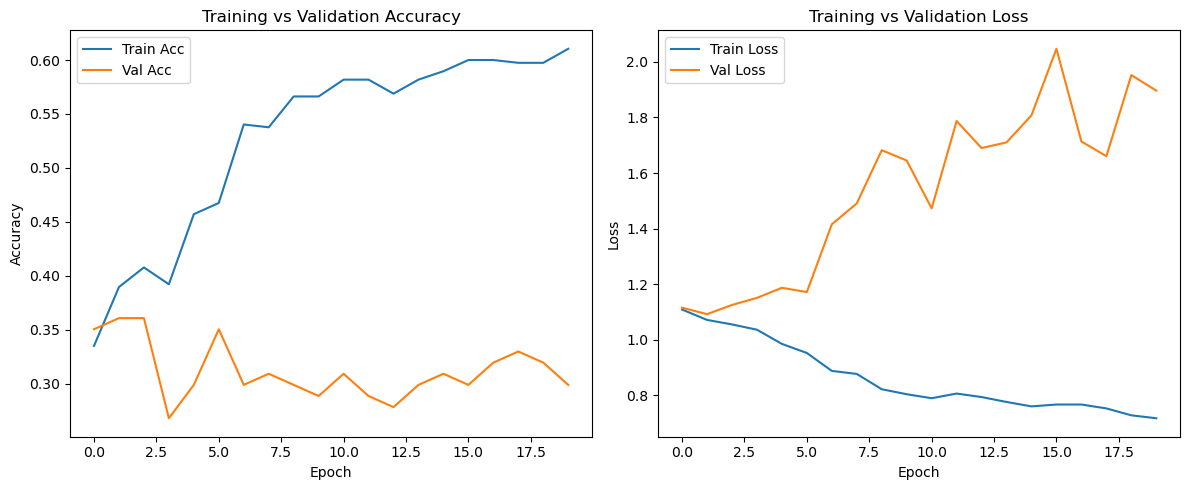

In [56]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history_elmo_sent)

In [220]:
def vader_to_label(score):
    """Mapping the headline VADER scores to match the supervised model scores"""
    if score <= -0.05:
        return 0  # negative
    elif score >= 0.05:
        return 2  # positive
    else:
        return 1  # neutral

corpus2['vader_to_lstm'] = corpus_df['headline_score'].apply(vader_to_label)

In [221]:
# returns difference between 0-2
corpus2['sentiment_diff'] = abs(corpus2['vader_to_lstm'] - corpus2['content_sentiment'])

In [222]:
# returns True or False for mismatch
corpus2['sentiment_mismatch'] = corpus2['vader_to_lstm'] != corpus2['content_sentiment']

In [223]:
corpus2

,headline,title,content,date,url,source,content_length,headline_people,headline_parties,content_people,content_parties,headline_score,headline_sentiment,content_sentiment,vader_to_lstm,sentiment_diff,sentiment_mismatch
0,New polling reveals Jacinta Allan’s support pl...,Polls reveals sharp drop in support for Jacint...,New polling has revealed support for Jacinta A...,2025-04-02,https://www.skynews.com.au/australia-news/poli...,skynews,406,[],[],"[Daniel Andrews, Andrews, Ms Allan, Allan, Jim...","[Coalition, Labor, Liberal]",0.1531,positive,0,2,2,True
1,Albanese’s major election push for group of Au...,Federal Election 2025: Labor to make submissio...,Labor will push the Fair Work Commission to gi...,2025-04-02,https://www.skynews.com.au/australia-news/poli...,skynews,424,[Anthony Albanese],[],"[Albanese, Anthony Albanese, Dutton, Peter Dut...","[Labor, Coalition, Australian Labor Party, Lib...",-0.6249,negative,0,0,0,False
2,Albanese hits back at Trump’s list of grievanc...,Anthony Albanese pressed on relationship with ...,Prime Minister Anthony Albanese has insisted h...,2025-04-01,https://www.skynews.com.au/australia-news/poli...,skynews,457,[Anthony Albanese],[],"[Albanese, Trump, Anthony Albanese, Donald Trump]",[Labor],-0.3612,negative,0,0,0,False
3,Bipartisan support to invest $150m for health ...,Coalition to match Labor's $150 million pledge...,A $150 million investment into a new healthcar...,2025-04-01,https://www.abc.net.au/news/2025-03-31/federal...,abc,749,[],[],"[Colin Stirling, Anthony Albanese, Mark Butler...","[Labor, Coalition, Liberal]",0.4019,positive,0,2,2,True
4,Coalition promises to relax home lending rules...,Coalition promises to relax home lending rules...,The Coalition is promising to relax rules arou...,2025-04-01,https://www.abc.net.au/news/2025-04-01/electio...,abc,659,[],[Coalition],"[Anthony Albanese, Peter Dutton, Michael Sukka...","[Coalition, National, Greens]",0.6705,positive,0,2,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,‘This is their job’: Qld mayor calls out Alban...,Mackay Mayor Greg Williamson says Bruce Highwa...,The Albanese government has been criticised fo...,2025-01-07,https://www.skynews.com.au/australia-news/poli...,skynews,841,[Anthony Albanese],[],"[Kenny Heatley, Cairns, Anthony Albanese, Bena...","[Labor, Coalition]",-0.4767,negative,2,0,2,True
498,Labor plunges $7.2bn to upgrade one of Austral...,Albanese government gives $7.2 billion funding...,Prime Minister Anthony Albanese has used his f...,2025-01-06,https://www.skynews.com.au/australia-news/poli...,skynews,553,[],[Labor],"[Bruce Highway, Cairns, Anthony Albanese, Cath...",[Liberal],0.0000,neutral,0,1,1,True
499,Anthony Albanese switches to election footing ...,Anthony Albanese switches to election footing ...,PM frames federal poll as choice between ‘buil...,2025-01-06,https://www.theguardian.com/australia-news/202...,theguardian,561,[Anthony Albanese],[],"[Cairns, Anthony Albanese, Albanese, Warren En...","[Labor, Coalition, Liberal]",-0.1531,negative,0,0,0,False
500,‘A huge hit for any family’: New emissions sta...,‘A huge hit for any family’: Coalition warns n...,The federal Coalition is warning Australian co...,2025-01-02,https://www.skynews.com.au/australia-news/poli...,skynews,402,[],[],"[Albanese, Jono Duniam, Duniam, David Littlepr...","[Coalition, Labor, Liberal]",0.3182,positive,0,2,2,True


/var/folders/z9/p4zgtcqn1xd4hnqfbwtb8vf80000gn/T/ipykernel_1150/696234824.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment_diff', data=corpus2, palette='muted')
/var/folders/z9/p4zgtcqn1xd4hnqfbwtb8vf80000gn/T/ipykernel_1150/696234824.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label_map.get(int(label.get_text()), "") for label in ax.get_xticklabels()])


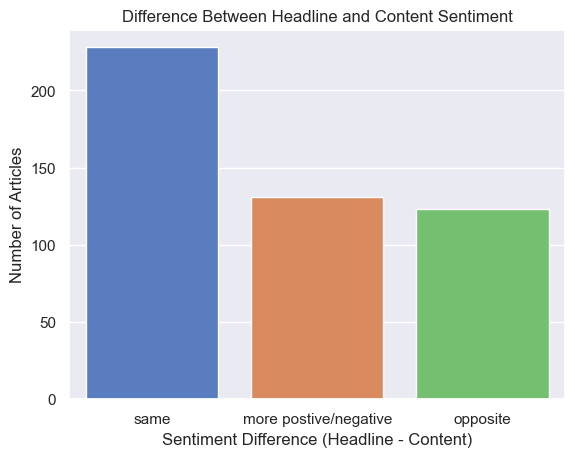

In [200]:
label_map = {0: "same", 1: "more postive/negative", 2: "opposite"}

ax = sns.countplot(x='sentiment_diff', data=corpus2, palette='muted')
plt.title('Difference Between Headline and Content Sentiment')
ax.set_xticklabels([label_map.get(int(label.get_text()), "") for label in ax.get_xticklabels()])
plt.xlabel('Sentiment Difference (Headline - Content)')
plt.ylabel('Number of Articles')
plt.show()

/var/folders/z9/p4zgtcqn1xd4hnqfbwtb8vf80000gn/T/ipykernel_1150/2784161051.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_mismatch', data=corpus2, palette='muted')


<Axes: xlabel='sentiment_mismatch', ylabel='count'>

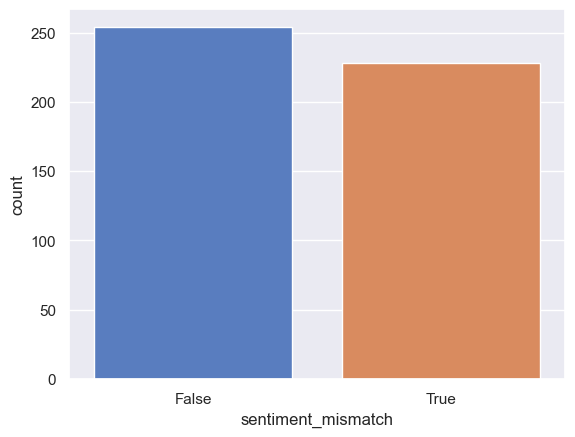

In [176]:
sns.countplot(x='sentiment_mismatch', data=corpus2, palette='muted')

In [141]:
sentiment_labels = pd.get_dummies(corpus_df['headline_sentiment']).columns
print(sentiment_labels)

Index(['negative', 'neutral', 'positive'], dtype='object')


In [151]:
corpus3 = corpus.copy()

In [179]:
import ast
cols_to_fix = ['headline_people', 'headline_parties', 'content_people', 'content_parties']
for col in cols_to_fix:
    corpus2[col] = corpus2[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [180]:
leader_aliases = {
    "Albanese": "Anthony Albanese",
    "Anthony Albanese": "Anthony Albanese",
    "Dutton": "Peter Dutton",
    "Peter Dutton": "Peter Dutton",
    "Bandt": "Adam Bandt",
    "Adam Bandt": "Adam Bandt",
    "Morrison": "Scott Morrison",
    "Scott Morrison": "Scott Morrison",
    "Marles": "Richard Marles",
    "Richard Marles": "Richard Marles",
    "Wong": "Penny Wong",
    "Penny Wong": "Penny Wong"
}

def normalize_leaders(person_list):
    return [leader_aliases[name] for name in person_list if name in leader_aliases]

corpus2['headline_people'] = corpus2['headline_people'].apply(normalize_leaders)

In [182]:
filtered_df = corpus2[corpus2['headline_people'].apply(lambda x: len(x) > 0)]


In [183]:
filtered_df.to_csv('filtered_df.csv', index=False)

/var/folders/z9/p4zgtcqn1xd4hnqfbwtb8vf80000gn/T/ipykernel_1150/2437644747.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  puor_colors = cm.get_cmap('PuOr', 3)


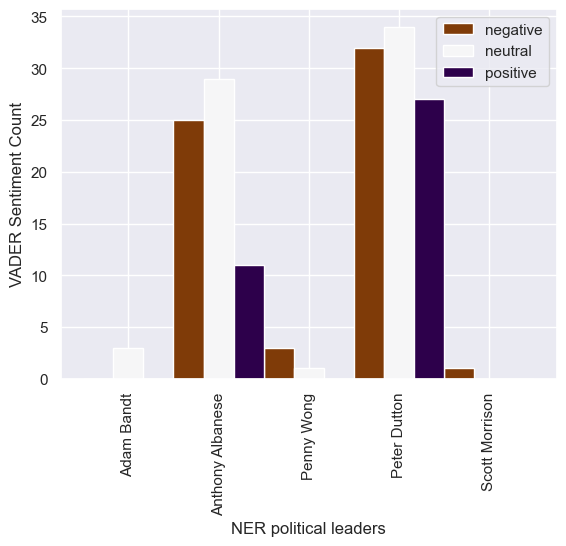

In [212]:
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
puor_colors = cm.get_cmap('PuOr', 3)
colors = [puor_colors(i) for i in range(3)]  # RGBA tuples
colors_hex = [plt.matplotlib.colors.to_hex(c) for c in colors]

exploded_df = filtered_df.explode('headline_people')
sentiment_counts = exploded_df.groupby(['headline_people', 'headline_sentiment']).size().unstack(fill_value=0)
sentiment_counts.plot(kind = 'bar', colormap = 'PuOr', width = 1)
plt.xlabel('NER political leaders')
plt.ylabel('VADER Sentiment Count')
plt.legend()

plt.show()

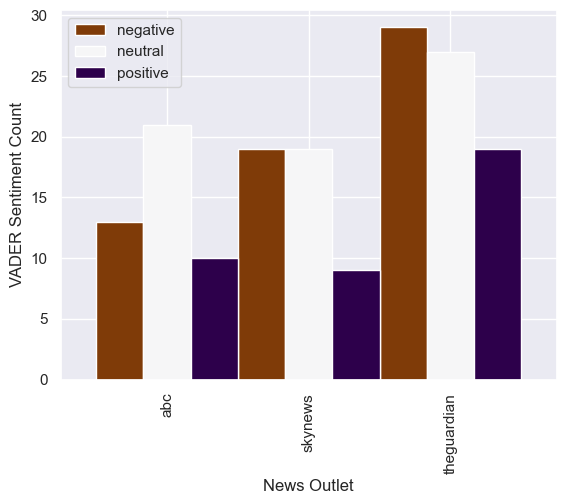

In [215]:
source_counts = exploded_df.groupby(['source', 'headline_sentiment']).size().unstack(fill_value=0)
source_counts.plot(kind = 'bar', colormap = 'PuOr', width = 1)
plt.legend()
plt.ylabel('VADER Sentiment Count')
plt.xlabel('News Outlet')
plt.show()

In [51]:
source_and_leader_counts = exploded_df.groupby(['source', 'headline_sentiment', 'headline_people']).size().unstack(fill_value=0)

In [52]:
source_and_leader_counts[['Anthony Albanese', 'Peter Dutton']]

headline_people                 Anthony Albanese  Peter Dutton
source      headline_sentiment                                
abc         negative                           6             8
            neutral                            9            12
            positive                           1             9
skynews     negative                          14             3
            neutral                           11             8
            positive                           5             4
theguardian negative                           7            24
            neutral                            9            14
            positive                           5            14

In [61]:
corpus_df['source'].unique()

array(['skynews', 'abc', 'theguardian'], dtype=object)

In [196]:
sentiment_order = ['negative', 'neutral', 'positive']
corpus_df['headline_sentiment'] = pd.Categorical(
    corpus_df['headline_sentiment'],
    categories=sentiment_order,
    ordered=True
)

/var/folders/z9/p4zgtcqn1xd4hnqfbwtb8vf80000gn/T/ipykernel_1150/3292325606.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


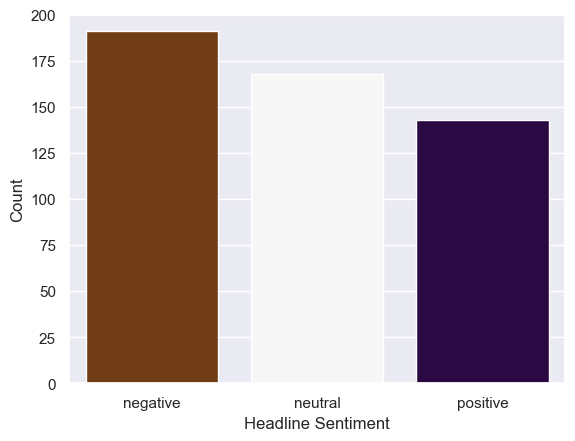

In [219]:
sns.countplot(
    data=corpus_df,
    x='headline_sentiment',
    order=sentiment_order,
    palette=colors
)
plt.xlabel('Headline Sentiment')
plt.ylabel('Count')
plt.show()


/var/folders/z9/p4zgtcqn1xd4hnqfbwtb8vf80000gn/T/ipykernel_1150/1867041546.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


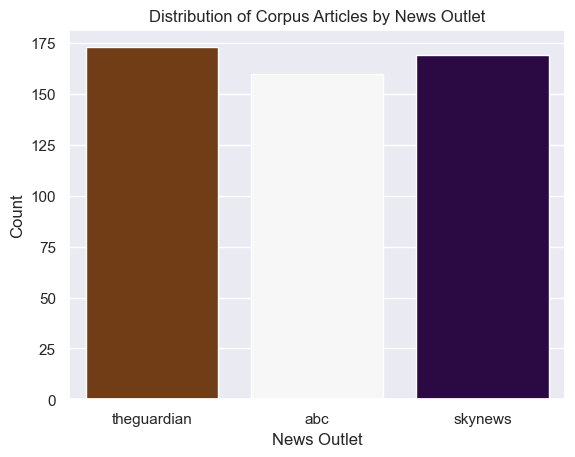

In [206]:
sns.countplot(
    data=corpus_df,
    x='source',
    order=['theguardian', 'abc', 'skynews'],
    palette=colors
)
plt.xlabel('News Outlet')
plt.ylabel('Count')
plt.title('Distribution of Corpus Articles by News Outlet')
plt.show()

/var/folders/z9/p4zgtcqn1xd4hnqfbwtb8vf80000gn/T/ipykernel_1150/63895824.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


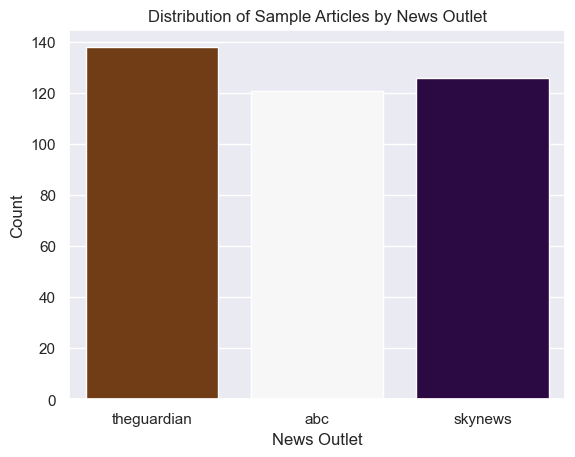

In [207]:
sns.countplot(
    data=corpus2.iloc[idx_train],
    x='source',
    order=['theguardian', 'abc', 'skynews'],
    palette=colors
)
plt.xlabel('News Outlet')
plt.ylabel('Count')
plt.title('Distribution of Sample Articles by News Outlet')
plt.show()
#sns.histplot(corpus2.iloc[idx_train]['source'], color='#b76b3e')